In [ ]:
!git clone https://github.com/omriallouche/text_classification_from_zero_to_hero.git
import os
os.chdir('text_classification_from_zero_to_hero')

# Bag of Words and Tf-Idf
## Part 2 of the Workshop "Text Classification - From Zero to Hero", by Dr. Omri Allouche, Gong.io, Bar Ilan University
In this notebook, we perform a very basic EDA (Exploratory Data Analysis) of the dataset, and build a basic classifier using Tf-Idf encoding.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams["axes.labelsize"] = 15

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,label,text,num_chars
0,talk.politics.mideast,i understand how israel captured the teritory ...,366
1,talk.politics.guns,and im sure that is a great comfort to the wid...,298
2,rec.sport.hockey,have a look at ed belfour. belfour kicked gerr...,288
3,talk.politics.mideast,deleted its noteworthy that the posts about th...,300
4,rec.sport.baseball,"recently, i heard the red sox on wrol a spanis...",365


In [3]:
df['label'].value_counts()

rec.sport.hockey         92
talk.politics.guns       91
rec.sport.baseball       88
talk.politics.mideast    85
Name: label, dtype: int64

Now let's fit a Tf-Idf vectorizer to these documents. We'll remove English stopwords, and check the words that have the highest Tfidf score for each class:

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

df_train = pd.read_csv('data/train.csv')
vectors = vectorizer.fit_transform(df_train['text'])
vectors.shape

(356, 3973)

In [5]:
df_train['tfidf'] = list(vectors.toarray())

In [6]:
inverse_vocab = {v: k for k,v in vectorizer.vocabulary_.items()}
top_terms = df_train.groupby('label')['tfidf'].apply(lambda x: x.sum(axis=0))
for i,r in top_terms.iteritems():
    print(i)
    print([inverse_vocab[x] for x in np.argsort(r)[-20:][::-1]])
    print()

rec.sport.baseball
['list', 'think', 'runs', 'team', 'did', 'dont', 'just', 'games', 'year', 'im', 'know', 'players', 'hit', 'good', 'nl', 'league', 'baseball', 'game', 'braves', 'sure']

rec.sport.hockey
['game', 'games', 'hockey', 'hawks', 'espn', 'team', 'think', 'players', 'know', 'season', 'wings', 'play', 'just', 'ice', 'blues', 'beat', 'leafs', 'like', 'im', 'way']

talk.politics.guns
['just', 'gun', 'people', 'dont', 'guns', 'children', 'government', 'weapons', 'control', 'com', 'believe', 'did', 'like', 'time', 'dave', 'warrant', 'know', 'note', 'cs', 'evidence']

talk.politics.mideast
['jews', 'israel', 'arabs', 'just', 'people', 'jewish', 'think', 'know', 'israeli', 'article', 'say', 'form', 'does', 'arab', 'zionism', 'freedom', 'dont', 'steve', 'holocaust', 'adam']



### Basic Classifier
Next, let's build a basic classifier. Let's use the Multinomial Naive Bayes.

We'll first fit the model on the train set:

In [7]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn import metrics

# We use the vectorizer we fitted earlier to transform the textual string into 
vectors = vectorizer.transform(df_train['text'])
vectors = vectors.toarray()
clf = MultinomialNB()
clf.fit(vectors, df_train['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

And then predict and evaluate performance on the validation set:

In [8]:
df['label'].value_counts()

rec.sport.hockey         92
talk.politics.guns       91
rec.sport.baseball       88
talk.politics.mideast    85
Name: label, dtype: int64

In [9]:
df_val = pd.read_csv('data/val.csv')
y_truth = df_val['label']
vectors_val = vectorizer.transform(df_val['text'])
vectors_val = vectors_val.toarray()
y_predict_proba = clf.predict_proba(vectors_val)
y_predict = clf.predict(vectors_val)

In [10]:
metrics.f1_score(y_truth, y_predict, average='macro')

0.7525962058313386

We see that even a simple model performs pretty well. Let's examine the most important features for each class:

In [11]:
def show_top_terms(classifier, vectorizer):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i in range(len(classifier.classes_)):
        top_terms = np.argsort(classifier.coef_[i])[-20:]
        print(classifier.classes_[i])
        print(", ".join(feature_names[top_terms]))
        print()

show_top_terms(clf, vectorizer)

rec.sport.baseball
sure, braves, game, baseball, league, nl, good, hit, players, know, im, year, games, just, dont, did, team, runs, think, list

rec.sport.hockey
way, im, like, leafs, beat, blues, ice, just, play, wings, season, know, players, think, team, espn, hawks, hockey, games, game

talk.politics.guns
evidence, cs, note, know, warrant, dave, time, like, did, believe, com, control, weapons, government, children, guns, dont, people, gun, just

talk.politics.mideast
adam, holocaust, steve, dont, freedom, zionism, arab, does, form, say, article, israeli, know, think, jewish, people, just, arabs, israel, jews



Let's further examine the classification report and the confusion matrix:

In [12]:
from src.model_evaluation_utils import plot_confusion_matrix, plot_precision_recall_curve, plot_confidence_performance

In [13]:
from sklearn import metrics
print(metrics.classification_report(y_truth, y_predict))

                       precision    recall  f1-score   support

   rec.sport.baseball       0.68      0.94      0.79        16
     rec.sport.hockey       0.77      0.85      0.81        20
   talk.politics.guns       0.81      0.77      0.79        22
talk.politics.mideast       0.82      0.50      0.62        18

            micro avg       0.76      0.76      0.76        76
            macro avg       0.77      0.77      0.75        76
         weighted avg       0.78      0.76      0.76        76



Normalized confusion matrix
[[0.9375     0.0625     0.         0.        ]
 [0.1        0.85       0.05       0.        ]
 [0.04545455 0.09090909 0.77272727 0.09090909]
 [0.22222222 0.11111111 0.16666667 0.5       ]]


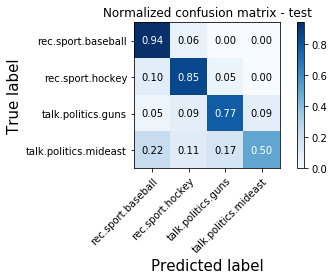

In [14]:
plot_confusion_matrix(y_truth, y_predict, normalize=True, title='Normalized confusion matrix - test');

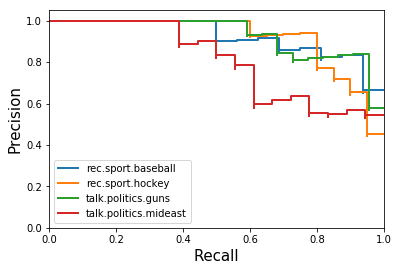

In [15]:
plot_precision_recall_curve(y_predict_proba, y_truth);

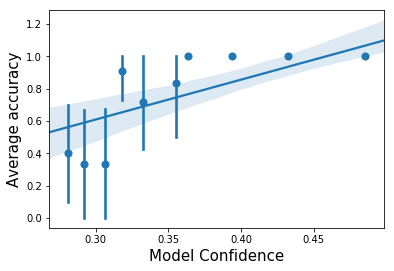

In [16]:
plot_confidence_performance(y_predict, y_predict_proba, y_truth, num_bins=10);

Next, let's perform an error analysis and manually review documents that are wrongly classified. We will focus on documents that have a high model confidence:

In [17]:
df_test = pd.read_csv('data/val.csv')
y_truth = df_test['label']
vectors_val = vectorizer.transform(df_val['text'])
y_predict_proba = clf.predict_proba(vectors_val)
y_predict = clf.predict(vectors_val)

In [18]:
df_test['y_predict'] = clf.predict(vectors_val)
df_test['y_predict_proba'] = np.max(clf.predict_proba(vectors_val), axis=1)
df_test['is_error'] = (y_predict != y_truth).astype(int)

In [19]:
df_test.sort_values('is_error', ascending=False).head()

,label,text,num_chars,y_predict,y_predict_proba,is_error
75,rec.sport.hockey,could someone post the flyers record with and ...,292,rec.sport.baseball,0.357701,1
67,talk.politics.guns,i agree very much. i have read almost every ar...,339,rec.sport.baseball,0.299778,1
24,talk.politics.mideast,our white knight for islam rides in again! our...,245,rec.sport.hockey,0.272949,1
58,talk.politics.mideast,is this group for real? i honestly cant believ...,315,rec.sport.hockey,0.299511,1
22,talk.politics.mideast,"peter, i think you are ridiculous here. stupid...",234,talk.politics.guns,0.318344,1


In [20]:
def print_document(r):    
    print('Document #{}. \nTrue label: {}. \nPredicted: {} (confidence: {:.1%})'.format(
        r.name,
        r['label'], 
        r['y_predict'],
        r['y_predict_proba']
    ))
    print()
    print(r['text'])

In [21]:
from ipywidgets import interact

@interact(i=(0,len(df_test)))
def explore_doc(i):
    print_document(df_test.iloc[i])

interactive(children=(IntSlider(value=38, description='i', max=76), Output()), _dom_classes=('widget-interact'…

(0, 600)

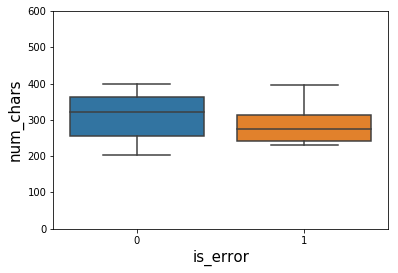

In [22]:
sns.boxplot(data=df_test, x='is_error', y='num_chars')
plt.ylim(0,600)

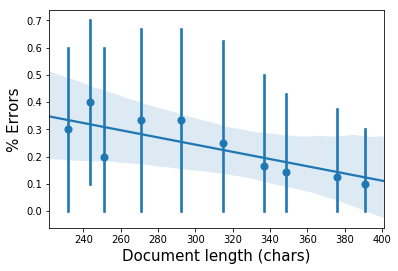

In [23]:
ax = sns.regplot(data=df_test, x='num_chars', y=df_test['is_error'], x_bins=10)
plt.xlabel('Document length (chars)');
plt.ylabel('% Errors');